# Pylops - sparse solvers for regression

This notebook concers with the solution of the following linear regression:

$$y_i =  x_0 + \sum_{k=1}^{K-1} t_{k,i} x_k  \quad \forall i=1,2,...,N$$

where we assume that out of the $K$ coefficients only a handful of them is non-zero.

Here we can express our problem in a matrical form:

$$\mathbf{y}=  \mathbf{A} \mathbf{x}$$

where:

$$\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad \mathbf{x}= [x_0, x_1, , x_{K-1}]^T, \qquad \mathbf{A}= 
\begin{bmatrix}
    1 & t_{1, 1} & t_{2, 1} & ... & t_{K-1, 1} \\ 
    1 & t_{1, 2} & t_{2, 2} & ... & t_{K-1, 2} \\
    .. & ..     \\
    1  & t_{1, N} & t_{2, N} & ... & t_{K-1, N}
\end{bmatrix}$$

Since we know that only few coefficients are non-zero, we can encode this information in our cost function, penalizing the L1 norm of our solution (soft constraint):

$$J = ||\mathbf{y} - \mathbf{A} \mathbf{x}||_2 + \lambda ||\mathbf{x}||_1 $$

or alternatively adding an hard constraint to the problem:

$$J =  ||\mathbf{x}||_1  \quad subj. to \quad \mathbf{y}=  \mathbf{A} \mathbf{x}$$

First of all we will show that we can easily solve the first functional using an out-of-the-box nonlinear solver. The need for a nonlinear solver is given by the second term (L1 norm).

We will then move on to using ad-hoc solvers that have been specifically developed for linear problems $\mathbf{y}=  \mathbf{A} \mathbf{x}$ with an additional L1 soft or hard constraint and see how out-of-the-box nonlinear solver which are generally great for full nonlinear problems (like optimizing the weights of a deep neural network) should not be favoured to more clever solvers when the problem at hand allow so.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from pylops.basicoperators import MatrixMult
from pylops.optimization.sparsity import FISTA, SPGL1
from pylops.utils import dottest

Lets create the problem

In [2]:
# parameters
order = 30
N = 51
x = np.zeros(order +1)
x[1] = 4
x[3] = 1
x[19] = 2

# set up problem
t = np.random.normal(0, 1, (N, order))
t = np.concatenate((np.ones((N, 1)), t), axis=1)
Lop = MatrixMult(t, dtype='float64')
dottest(Lop, N, order+1, verb=True)

y = Lop*x

Dot test passed, v^T(Opu)=30.180477 - u^T(Op^Tv)=30.180477


And solve it with least-squares solvers

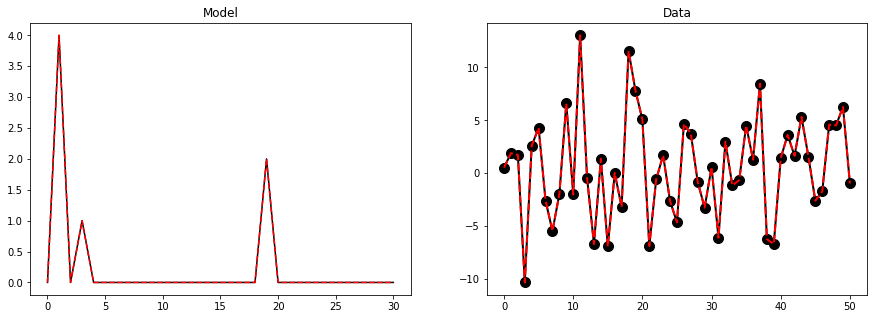

In [3]:
# LSQR solver
xlsqr, istop, itn, r1norm, r2norm = lsqr(Lop, y, damp=1e-10, iter_lim=100, show=0)[0:5]

# Apply
ylsqr = Lop * xlsqr

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xlsqr, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(ylsqr, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

Let's now add the sparsity constraint and solve it with an out-of-the-box nonlinear solver

In [4]:
def fun(x, yobs, L, lam):
    y = np.dot(L, x)
    j = np.linalg.norm(yobs - y) + lam*np.linalg.norm(x, ord=1)
    return j

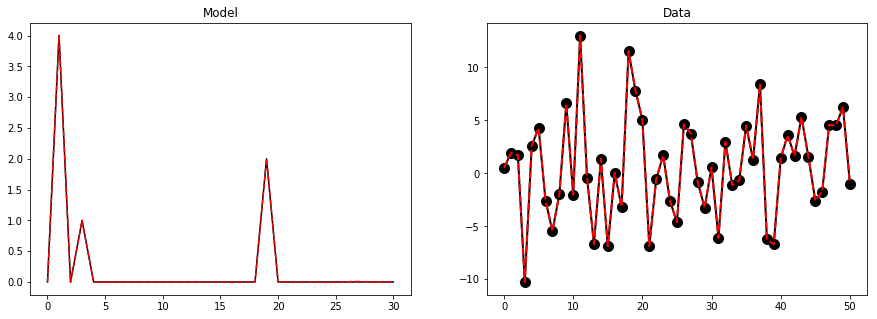

In [5]:
lam = .5
f = lambda x: fun(x, y, Lop.A, lam)
#nl = minimize(f, np.random.normal(0, 2, order+1))
nl = minimize(f, np.zeros(order+1), options=dict(maxiter=40))
xnl = nl.x

#Apply
ynl = Lop * xnl

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xnl, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(ynl, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

We now use FISTA to solve the same problem with soft constraint

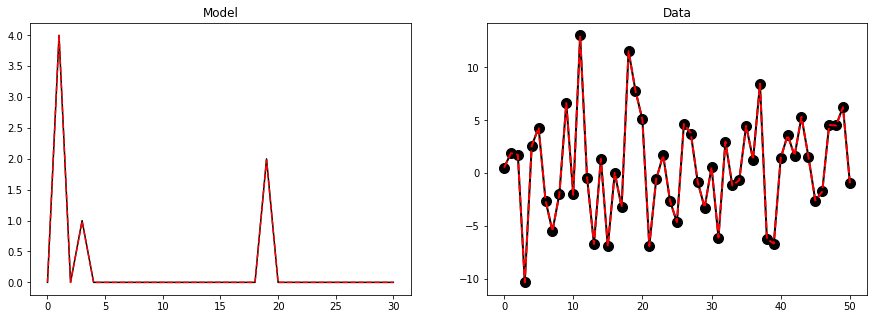

In [6]:
xfista, niterf, costf = FISTA(Lop, y, niter=100, eps=lam, tol=1e-2, returninfo=True)

# Apply
yfista = Lop * xfista

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xfista, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(yfista, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

And SPGL1 for the problem with hard constraint


SPGL1
No. rows              :       51     
No. columns           :       31

Initial tau           : 0.00e+00     
Two-norm of b         : 3.48e+01

Optimality tol        : 1.00e-04     
Target objective      : 1.00e-01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       50

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  3.4790291e+01  0.0000000e+00   9.97e-01  2.582e+02     0.0       0       0  4.6742816e+00
    1  2.4946006e+01  1.9285140e+00   9.96e-01  1.789e+02    -0.6      31       1               
    2  1.2163309e+01  1.1702310e+00   9.92e-01  6.768e+01     0.0      11       1               
    3  8.6425050e+00  5.0809559e-01   9.88e-01  3.626e+01     0.0       3       1               
    4  8.5421558e+00  2.0488965e-01   9.88e-01  3.243e+01     0.0       3       1               
    5  8.5379812e+00  1.0094771e-02   9.88e-01  3.165e+01     0.0       3       1               
    6  8.5378729e+00  2.0938055e

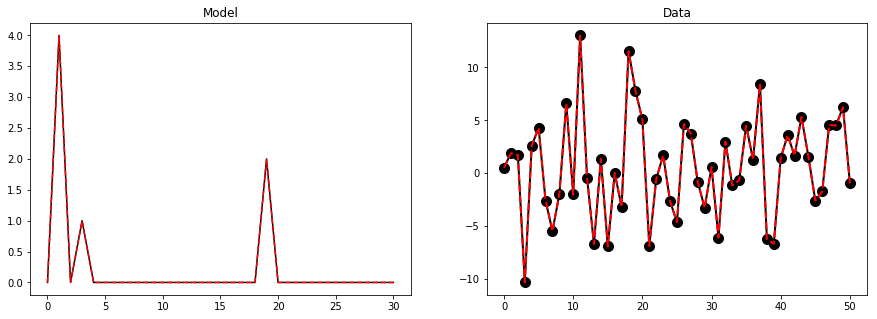

In [7]:
xspgl1 = SPGL1(Lop, y, sigma=1e-1, iter_lim=50, verbosity=2)[0]

# Apply
yspgl1 = Lop * xspgl1

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xspgl1, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(yspgl1, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

We can see that all of them have been succesful. But which one costs us the most?

In [8]:
%timeit minimize(f, np.zeros(order+1), options=dict(maxiter=40))
%timeit FISTA(Lop, y, niter=100, eps=1e-3, tol=1e-2, returninfo=True)
%timeit SPGL1(Lop, y, sigma=1e-1, iter_lim=50, verbosity=0)[0]

49.4 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.42 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.15 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ok, not surprising!! If you throw yourself in the hand of out-of-the-box nonlinear solver (which do not know much about the structure of your problem other than how to numerically evaluate its cost function) you will pay the price. 

In this case, it took about 5 to 10 times longer to use scipy.optimize.minimize compared to FISTA or SPGL1. This is not to say that scipy.optimize.minimize is a poor choice, it is a good choice when you can't take advantage of more specialized solvers for your cost function. Adding a L1 term makes your problem non linear and so linear solvers like CG or LSQR cannot help, however there is a wealth of more advanced solvers in this area which should always be favoured to out-of-the-box nonlinear solvers if your problem (LS term of cost function) is inherently linear.

In summary, this may look like a small, fairly useless toy example. There are however many problems where mixed L2-L1 norm cost functions are very helpful to create solutions that have a certain structure (either sparse or with blocky) and where you will definitely not like to spend time waiting for scipy.optimize.minimize to solve your cost function.

For some examples head over to:

- 1d interpolation: https://pylops.readthedocs.io/en/latest/tutorials/solvers.html#sphx-glr-tutorials-solvers-py
- 2d seismic interpolation: https://pylops.readthedocs.io/en/latest/tutorials/seismicinterpolation.html
- sparse least-squares migration: https://pylops.readthedocs.io/en/latest/tutorials/lsm.html